# NCoR QC

In [19]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2

In [20]:
### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
matplotlib.rcParams['savefig.dpi'] = 100
import seaborn as sns
from IPython.display import Image, display

## Preprocessing

In [24]:
# file directories
workingDirectory = '/home/jenhan/analysis/ncor_analysis/'
binDirectory = '/home/jenhan/bin/'
genomePath = '/bioinformatics/homer/data/genomes/mm10'

peakDirectory = workingDirectory + 'peaks/'
scratchDirectory = workingDirectory + '/scratch/'
logFilePath = workingDirectory + '/log_files_chip/'
tagDirectory = workingDirectory + '/tag_directories_chip/'
bamDirectory  = workingDirectory + '/bam/'
samDirectory  = workingDirectory + '/sam/'
inputDirectory = workingDirectory + '/input/'
os.chdir(workingDirectory)

# map ugly file names to prettier looking file names
if not os.path.isfile("nameMapping_chip.tsv"):
    nameMappingFile = open("nameMapping_chip.tsv", "w")
    for f in os.listdir(logFilePath):
        rootName = f.replace('.fastq.mm10.bowtie2.log','')
        nameMappingFile.write(rootName + '\t' + rootName + '\n')
    nameMappingFile.close()

# read in and parse name mapping file and create a DataFrame representation
with open("nameMapping_chip.tsv") as f:
    data = f.readlines()
strains = []
cellTypes = []
experiments = []
factors = []
treatments = []
owners = []
dates = []
originalNames = []
cleanedNames = []
for line in data:
    tokens = line.strip().split("\t")
    originalName = tokens[0]
    metaDataTokens = tokens[1].split('_')
    
    originalNames.append(originalName)
    cleanedNames.append(tokens[1])
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip()
    cellType = metaDataTokens[1].strip()
    experiment = metaDataTokens[2].strip()
    factor = metaDataTokens[3].strip()
    treatment = metaDataTokens[4].strip()
    owner = metaDataTokens[5].strip()
    date = metaDataTokens[6].strip()
    
    # append to overall lists
    strains.append(strain)
    cellTypes.append(cellType)
    experiments.append(experiment)
    factors.append(factor)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes, 
                                  experiments, 
                                  factors, treatments, 
                                  owners, 
                                  dates, 
                                  originalNames, 
                                  cleanedNames]).transpose()
metadata_frame.columns = ['strain', 
                         'cellType', 
                         'experiment', 
                         'factor', 
                         'treatment', 
                         'owner', 
                         'date', 
                         'originalName', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.lower().replace('-1h','').replace('dsgfa-','')
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

# create dictionary for convenience
originalName_cleanedName_dict = dict(zip(metadata_frame["originalName"], metadata_frame["sampleName"])) # {originalName:newName}
cleanedName_originalName_dict = dict(zip(metadata_frame["sampleName"], metadata_frame["originalName"])) # {newName:originalName}

### read in log files ###

# create data frame summarizing mapping quality logs
# _sampleNames = []
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_originalNames =[]
for logFile in os.listdir(logFilePath):
    with open(logFilePath + '/' + logFile) as f:
        data = f.readlines()
        
    rootName = logFile.replace('.fastq.mm10.bowtie2.log','')
    
    totalReads = int(data[0].split()[0])
    unpairedReads = int(data[1].split()[0])
    unmappedReads = int(data[2].split()[0])
    uniquelyMappedReads = int(data[3].split()[0])
    multiMappedReads = int(data[4].split()[0])

    _originalNames.append(rootName)
    _totalReads.append(totalReads)
    _unpairedReads.append(unpairedReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)

mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads]).transpose()
mappingStats_frame.columns = ['originalName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []

for simpleNameRoot in list((metadata_frame['strain'] + '_' + metadata_frame['factor'] + '_' + metadata_frame["simpleTreatment"]).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

metadata_frame["simplifiedName"] = simplifiedNames
    
sampleName_simpleName_dict = dict(zip(metadata_frame["sampleName"], metadata_frame["simplifiedName"])) # {newName:simplifiedName}
simpleName_sampleName_dict = dict(zip(metadata_frame["simplifiedName"], metadata_frame["sampleName"])) # {simplifiedName:newName}

originalName_simpleName_dict = dict(zip(metadata_frame["originalName"], metadata_frame["simplifiedName"]))
simpleName_originalName_dict = dict(zip(metadata_frame["simplifiedName"], metadata_frame["originalName"])) 

summary_frame = metadata_frame.merge(mappingStats_frame, on='originalName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['factor'].values), list(summary_frame['simpleTreatment'].values)])
summary_frame = summary_frame.sort()

## Call Peaks

In [26]:
veh_input_dict = {'14-11-04':inputDirectory + 'Sample_NCoRWT_BMDM_Input-Form_NoTx_JSS_14_11_04',
                  '14-03-19':inputDirectory + 'Sample_NCoRWT_BMDM_Input-Form_NoTx_JSS_14_11_04',
                  '14-07-07':inputDirectory + 'Sample_NCoRWT_BMDM_Input-Form_NoTx_JSS_14_11_04',
                  '14-10-23':inputDirectory + 'Sample_Coro2AWT_BMDM_ChIP_Input_NoTx_JSS_14_10_23',
                  '14-09-17':inputDirectory + 'Sample_Coro2AWT_BMDM_ChIP_NCoR-p65-Input_NoTx_JSS_14_09_17',
                  '15-02-02':inputDirectory + 'Sample_Coro2AWT_BMDM_ChIP_Input_NoTx_JSS_15_02_02'
                  }
kla_input_dict = {'14-11-04':inputDirectory + 'Sample_NCoRWT_BMDM_Input-DSG_KLA_1h_JSS_14_11_04',
                  '14-03-19':inputDirectory + 'Sample_NCoRWT_BMDM_Input-DSG_KLA_1h_JSS_14_11_04',
                  '14-07-07':inputDirectory + 'Sample_NCoRWT_BMDM_Input-DSG_KLA_1h_JSS_14_11_04',
                  '14-10-23':inputDirectory + 'Sample_Coro2AWT_BMDM_ChIP_Input_KLA_1h_JSS_14_10_23',
                  '14-09-17':inputDirectory + 'Sample_Coro2AWT_BMDM_ChIP_NCoR-p65-Input_KLA_1h_JSS_14_09_17',
                  '14-09-26':inputDirectory + 'Sample_Coro2AWT_BMDM_ChIP_NCoR-p65-Input_KLA_1h_JSS_14_09_17',
                  '15-02-02':inputDirectory + 'Sample_Coro2AWT_BMDM_ChIP_Input_NoTx_JSS_15_02_02'
                  }

# iterate through each individual file
if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
scriptFile = open(scratchDirectory + '/peakCalling_homer_relaxed.sh', 'w')
for tagDir in os.listdir(tagDirectory):
    # call peaks only for experiments that passed thresholding
    metaDataTokens = originalName_cleanedName_dict[tagDir].split("_")
    strain = metaDataTokens[0]
    factor = metaDataTokens[3]
    treatment = metaDataTokens[4]
    date = metaDataTokens[6]
    print(tagDir)
    peakFileName = originalName_simpleName_dict[tagDir] + "_homer_relaxed_peaks.tsv"
    if "veh" in treatment.lower():
        inputDir = veh_input_dict[date]
    elif "kla" in treatment.lower():
            inputDir = kla_input_dict[date]
    scriptFile.write('findPeaks ' + tagDirectory + '/' + tagDir + 
                     ' -i ' + inputDir + 
                     ' -L 0 -C 0 -fdr 0.9 -style factor -size 100  > ' + 
                     peakDirectory + peakFileName + ' &\n')

scriptFile.close()


Sample_Coro2AWT_BMDM_ChIP_NCoR_KLA_1h_JSS_15_02_02
Sample_NCoRWT_BMDM_NCoR_KLA_1h_JSS_14_11_04
Sample_WT_BMDM_NCoR_Veh_14_03_19
Sample_Coro2AWT_BMDM_ChIP_NCoR_KLA_1h_JSS_14_09_26
Sample_Coro2AWT_BMDM_ChIP_NCoR_KLA_1h_JSS_14_10_23
Sample_NCoRWT_BMDM_NCoR_NoTx_JSS_14_11_04
Sample_Coro2AWT_BMDM_ChIP_NCoR_KLA_1h_JSS_14_09_17
Sample_WT_BMDM_NCoR_Millipore_Veh_1h_14_07_07
Sample_WT_BMDM_NCoR_Millipore_KLA_1h_14_07_07
Sample_Coro2AWT_BMDM_ChIP_NCoR_NoTx_JSS_15_02_02
Sample_WT_BMDM_NCoR_KLA_1h_14_03_19
Sample_Coro2AWT_BMDM_ChIP_NCoR_NoTx_JSS_14_09_17
Sample_Coro2AWT_BMDM_ChIP_NCoR_NoTx_JSS_14_10_23


In [27]:
%%bash
bash $scratchDirectory/peakCalling_homer_relaxed.sh

bash: /peakCalling_homer_relaxed.sh: No such file or directory


## Mapping Quality Control

In [200]:
if not os.path.exists(scratchDirectory):
    os.mkdir(scratchDirectory)

# delete all empty files
if os.path.exists(scratchDirectory):
    for f in os.listdir(scratchDirectory):
        if os.stat(scratchDirectory + '/' + f).st_size == 0 and 'annotated' in f:
            os.remove(scratchDirectory + '/' + f)

scriptFile = open(scratchDirectory + '/homer_peak_annotation.sh', 'w')

count = 0 
sleepTime = 0
peakFiles = os.listdir(peakDirectory)
for peakFile in peakFiles:
    if "homer_peaks" in peakFile:
        annotatedFile = peakFile.replace("_homer_peaks.tsv","") + "_homer_annotated.tsv"
        simpleName_sampleName_dict[peakFile.replace("_homer_peaks.tsv","")]
        tagDir1 = cleanedName_originalName_dict[simpleName_sampleName_dict[peakFile.replace("_homer_peaks.tsv","")]]
        # annotate peaks with tag counts
        count += 1
        if count == 10:
            count = 0
            sleepTime += 1
        scriptFile.write('(sleep ' + str(sleepTime) +'m; annotatePeaks.pl '+
                         peakDirectory + '/' + peakFile +
                         ' mm10 -noadj -noann -nogene -d ' +
                         tagDirectory + '/' + tagDir1 + '> ' +
                         scratchDirectory + '/' + annotatedFile +') & \n')
scriptFile.close()

# run script
! bash $scratchDirectory/homer_peak_annotation.sh

In [207]:
sampleName_mappedReadsDict = dict(zip(summary_frame['originalName'], summary_frame['totalReads'] - summary_frame['unmappedReads']))
sampleName_spot_dict = {}
mappedReadsInPeaks = []
for p in os.listdir(scratchDirectory):
    if 'homer_annotated' in p:
        with open(scratchDirectory + '/' + p) as f:
            data = f.readlines()
        simpleName = p.replace('_homer_annotated.tsv','')
        originalName = simpleName_originalName_dict[simpleName]
        totalTagCount = 0
        for line in data[1:]: # first line is head
            # last column in annotated file gives tag counts
            tokens = line.strip().split("\t")
            tagCount = float(tokens[-1])
            totalTagCount +=tagCount
            totalMappedReads = sampleName_mappedReadsDict[originalName]
            spot = totalTagCount/totalMappedReads
        mappedReadsInPeaks.append(totalTagCount)
        sampleName_spot_dict[originalName] = spot
summary_frame['spot'] = [sampleName_spot_dict[x] for x in summary_frame['originalName'].values]
        

### Plot Distributions of Mapping Statistics

<function xticks at 0x7f692f3c2ea0>


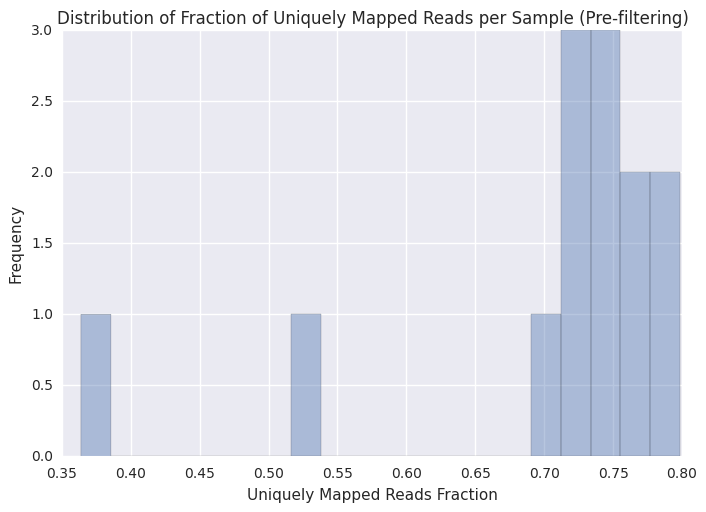

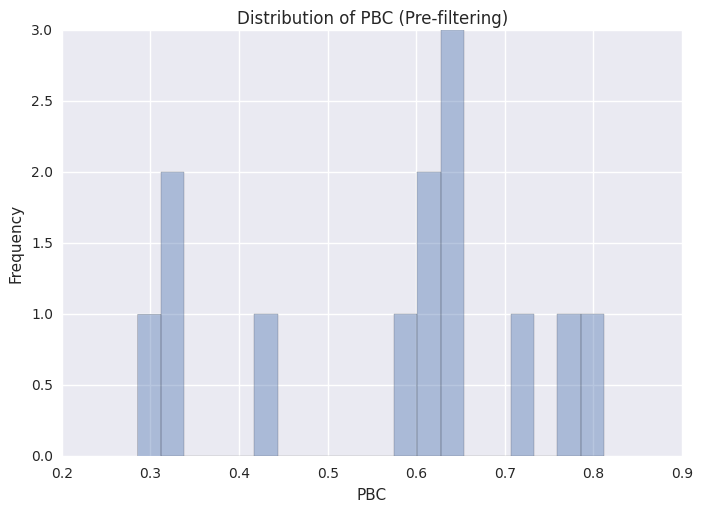

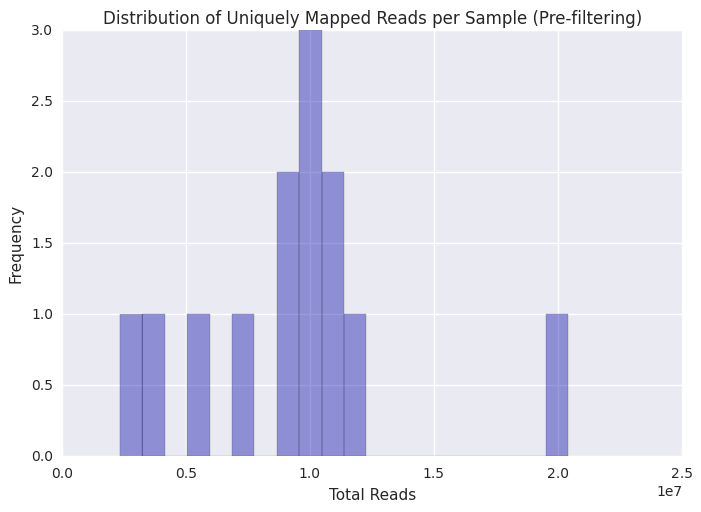

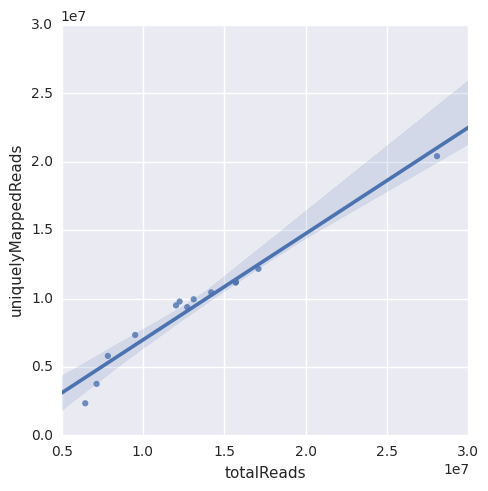

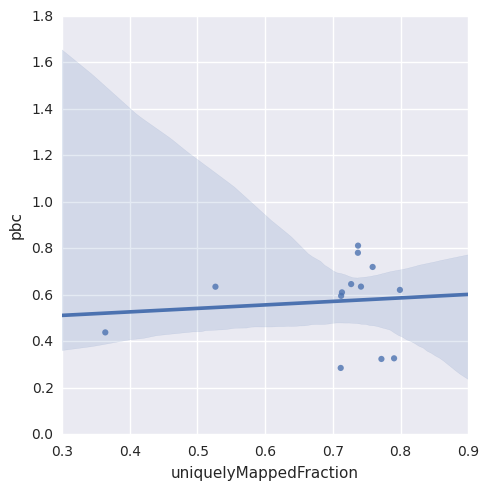

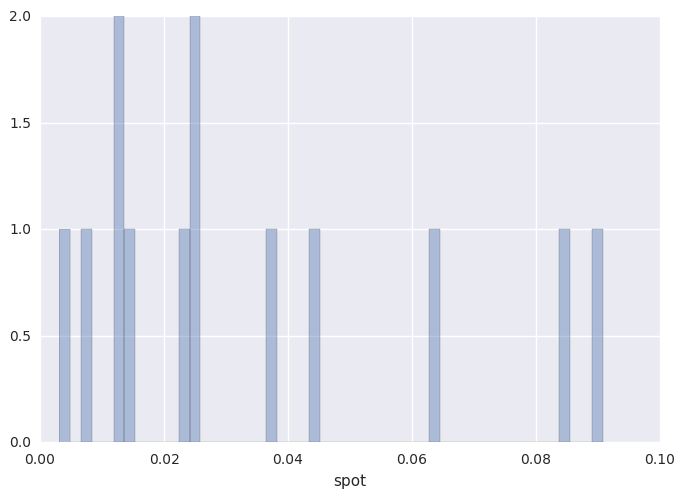

In [208]:
# plot distribution of uniquely mapped reads
sns.distplot(summary_frame['uniquelyMappedFraction'], bins=20, kde=False)
print(plt.xticks)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# plot distribution of PBC
sns.distplot(summary_frame['pbc'], bins=20, kde=False)
plt.title('Distribution of PBC (Pre-filtering)')
plt.xlabel('PBC')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(summary_frame['uniquelyMappedReads'], bins=20, kde=False, color=sns.xkcd_rgb["royal blue"])
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

sns.lmplot(x='totalReads', y='uniquelyMappedReads', data= summary_frame)
plt.show()

sns.lmplot(x='uniquelyMappedFraction', y='pbc', data= summary_frame)
plt.show()

sns.distplot(summary_frame['spot'], kde=False, bins =50)
plt.show()


### Filter Samples According to Mapping Quality

In [17]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 5000000
pbcThreshold=0.3
spotThreshold = 0.005

filtered_summary_frame = summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['mappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]
print(filtered_summary_frame.shape)
#filter on PBC
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['pbc'] >= pbcThreshold]
print(filtered_summary_frame.shape)
#filter on spot
# filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['spot'] >= spotThreshold]
# print(filtered_summary_frame.shape)


# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])



(11, 19)
(10, 19)
Number of Samples: 13
Number of discarded samples: 3
Number of Samples remaining after filtering: 10


<function xticks at 0x7f692f3c2ea0>


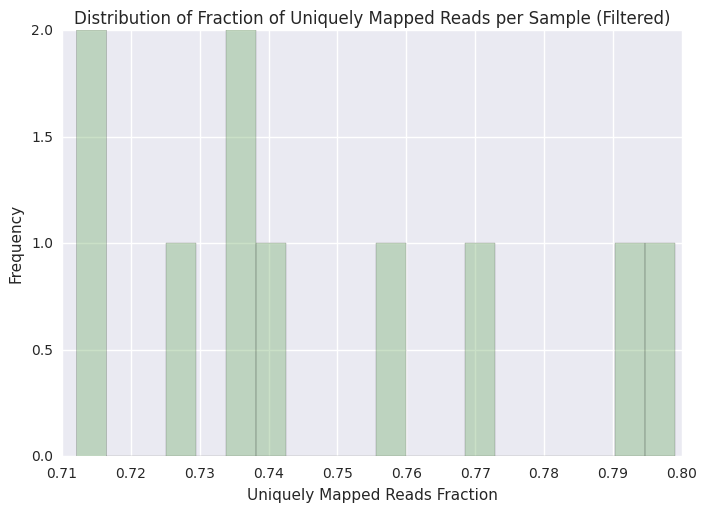

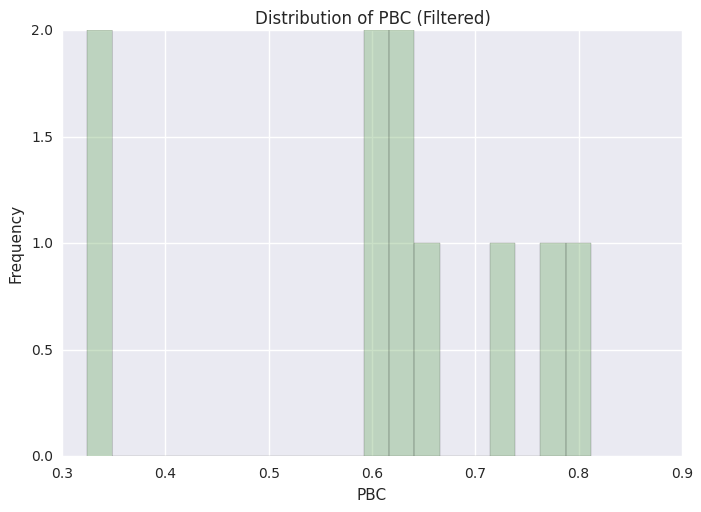

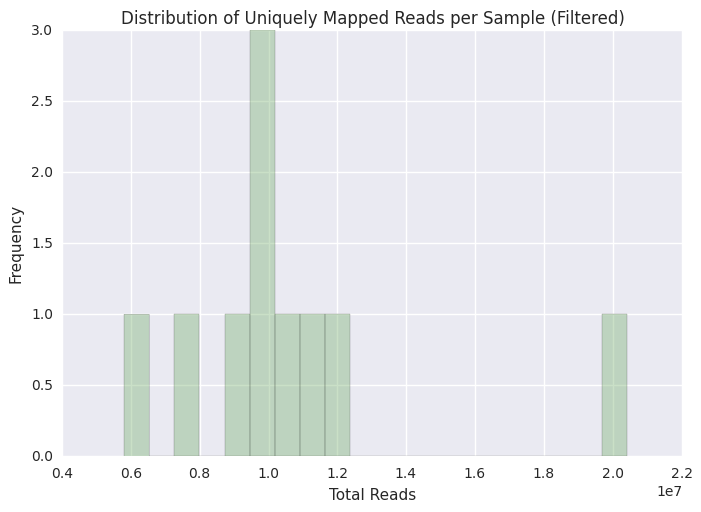

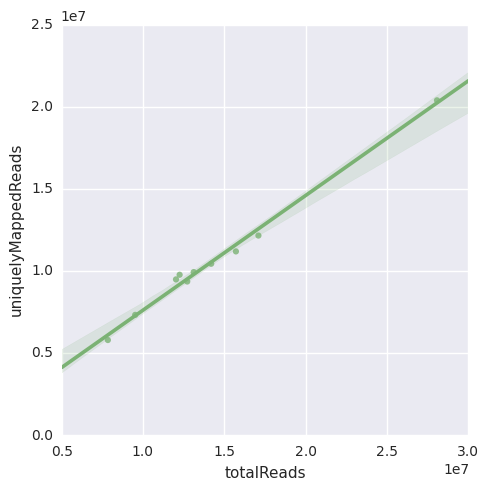

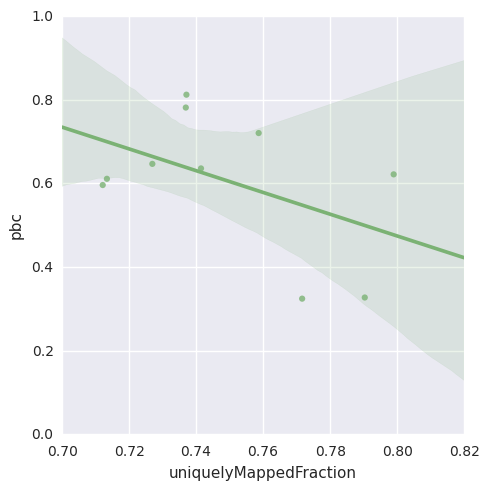

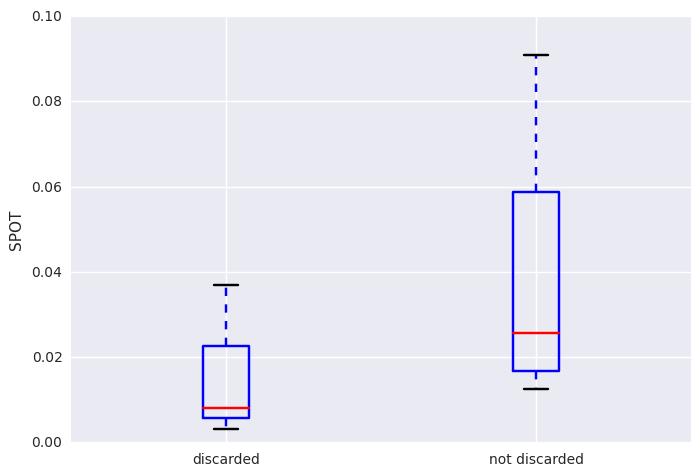

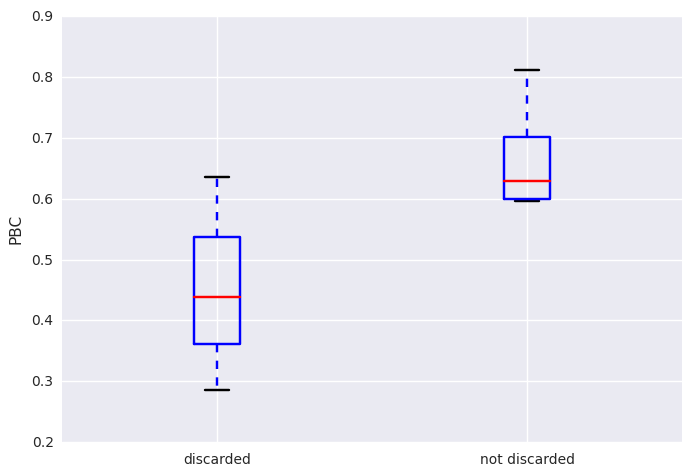

In [211]:
# plot distribution of uniquely mapped reads
sns.distplot(filtered_summary_frame['uniquelyMappedFraction'], bins=20, kde=False, color=sns.xkcd_rgb['faded green'])
print(plt.xticks)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Filtered)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# plot distribution of PBC
sns.distplot(filtered_summary_frame['pbc'], bins=20, kde=False, color=sns.xkcd_rgb['faded green'])
plt.title('Distribution of PBC (Filtered)')
plt.xlabel('PBC')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(filtered_summary_frame['uniquelyMappedReads'], bins=20, kde=False, color=sns.xkcd_rgb['faded green'])
plt.title('Distribution of Uniquely Mapped Reads per Sample (Filtered)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

sns.lmplot(x='totalReads', y='uniquelyMappedReads', data= filtered_summary_frame, color=sns.xkcd_rgb['faded green'])
plt.show()

sns.lmplot(x='uniquelyMappedFraction', y='pbc', data= filtered_summary_frame, color=sns.xkcd_rgb['faded green'])
plt.show()

plt.boxplot([discarded_summary_frame["spot"], filtered_summary_frame["spot"]])
plt.xticks([1, 2], ["discarded", "not discarded"])
plt.ylim([0,0.1])
plt.ylabel('SPOT')
plt.show()

plt.boxplot([discarded_summary_frame["pbc"], filtered_summary_frame["pbc"]])
plt.xticks([1, 2], ["discarded", "not discarded"])
plt.ylabel('PBC')
plt.show()



In [5]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]

raw_frame = pd.read_csv("raw.tsv",sep="\t")
columns = raw_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "reads" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
raw_frame.columns = columns  
raw_frame['gene'] = [x.split("|")[0] for x in raw_frame['Annotation/Divergence']]
columns = list(raw_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
raw_frame = raw_frame[columns]

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']], rpkm_frame['refseq'].values))


# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame['originalName'].values]]
columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.refseq.values
# get rid of genes that aren't expressed at all
filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.sum(axis=1) > 10.0]

# create frame that's easier to use with factor plots
pivoting_frame = filtered_rpkm_frame.transpose()
_refseq = []
_gene = []
_rpkm = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(filtered_summary_frame['simpleTreatment'].values) * pivoting_frame.shape[1]
for refseq in pivoting_frame.columns:
    gene = refseq_gene_mapping[refseq]
    for rpkm in pivoting_frame[refseq].values:
        _rpkm.append(rpkm)
        _refseq.append(refseq)
        _gene.append(gene)
filtered_rpkm_plottingFrame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'rpkm': _rpkm,
'simplifiedName': _simplifiedName,
'treatment': _treatment
})
del pivoting_frame
        
filtered_rpkm_plottingFrame_log = filtered_rpkm_plottingFrame.copy()
filtered_rpkm_plottingFrame_log['rpkm'] = np.log2(filtered_rpkm_plottingFrame.rpkm)




NameError: name 'filtered_summary_frame' is not defined